In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(1)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetAltura/train
# !mkdir ../datasetAltura/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetAltura'),
#                 image.replace('datasetClean','../datasetAltura/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetAltura'),
#                 image.replace('datasetClean','../datasetAltura/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
def getDataBlock(presize=224,size=224):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_masa,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True), Normalize.from_stats(*imagenet_stats)])

In [13]:
path = Path('../datasetAltura2/')
trainPath = path/'train'

In [14]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=16)

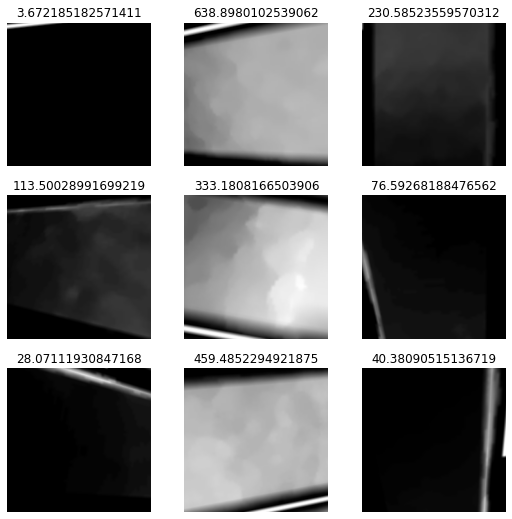

In [15]:
dls.show_batch()

In [16]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnet50Masav2Height')
]

In [17]:
from fastai.metrics import mae,rmse,mse

In [18]:
learn = cnn_learner(dls,resnet50,loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,109690.203125,125500.609375,287.290558,354.260681,125500.609375,00:03


Better model found at epoch 0 with valid_loss value: 125500.609375.


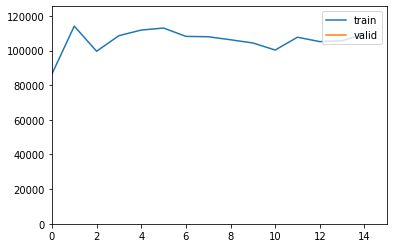

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,106189.937500,124192.000000,286.222443,352.408844,124192.000000,00:03
1,106087.679688,121041.210938,284.672089,347.909760,121041.210938,00:03
2,105393.062500,118370.515625,283.513367,344.050140,118370.515625,00:03
3,104891.742188,114244.414062,280.640381,338.000610,114244.414062,00:03
4,104824.656250,113140.375000,280.433502,336.363434,113140.375000,00:03
5,103848.460938,111762.640625,279.828857,334.309204,111762.640625,00:03
6,103856.382812,111763.804688,280.816315,334.310913,111763.804688,00:03
7,103651.687500,109489.007812,278.115814,330.891235,109489.007812,00:03
8,103439.945312,110944.507812,279.832672,333.083344,110944.507812,00:03
9,102793.148438,109180.476562,277.442993,330.424683,109180.476562,00:03


Better model found at epoch 0 with valid_loss value: 124192.0.


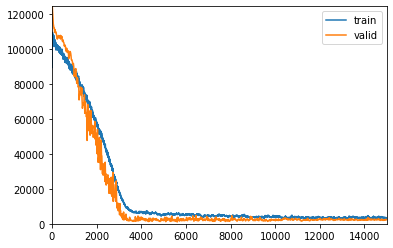

Better model found at epoch 1 with valid_loss value: 121041.2109375.
Better model found at epoch 2 with valid_loss value: 118370.515625.
Better model found at epoch 3 with valid_loss value: 114244.4140625.
Better model found at epoch 4 with valid_loss value: 113140.375.
Better model found at epoch 5 with valid_loss value: 111762.640625.
Better model found at epoch 7 with valid_loss value: 109489.0078125.
Better model found at epoch 9 with valid_loss value: 109180.4765625.
Better model found at epoch 12 with valid_loss value: 108575.2890625.
Better model found at epoch 13 with valid_loss value: 107537.234375.
Better model found at epoch 14 with valid_loss value: 106573.6875.
Better model found at epoch 15 with valid_loss value: 105509.640625.
Better model found at epoch 25 with valid_loss value: 105501.8359375.
Better model found at epoch 30 with valid_loss value: 104329.3046875.
Better model found at epoch 33 with valid_loss value: 103675.7265625.
Better model found at epoch 35 with va

In [20]:
learn.fine_tune(1000,base_lr=1e-3)

In [21]:
# learn.load('resnetrs50Masav2Height')

In [22]:
# df[df['image_id']=='datasetClean/br_2022-01-07T10-54-11.tif']

In [23]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [24]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_masa,
                 item_tfms = Resize(224),
                 batch_tfms=[*aug_transforms(size=224,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [25]:
dlstest = dbtest.dataloaders(path,bs=16)

In [26]:
learn.dls=dlstest

In [27]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 31.685546875.


(#4) [1635.3948974609375,31.685546875,40.44001770019531,1635.3948974609375]

In [28]:
from sklearn.metrics import mean_absolute_error

In [29]:
preds,gt = learn.tta()

In [30]:
mean_absolute_error(gt,preds)

27.029154